# 🏘️ Main Street Negotiation - Comprehensive Analysis Dashboard - Cleaned
Complete analysis of Main Street real estate negotiations (Fred Starr vs Rosalind Cain)

Analysis Sections:
1. 📋 All Negotiation Records Overview
2. 👥 Student Demographics & Characteristics Analysis
3. 💰 Configuration Comparison: Base vs M vs M+P (Price Analysis)
4. 🧠 Memory (M) Evolution Tracking
5. 🎯 Planning (P) Strategy Tracking
6. 💬 Full Transcript Viewer
7. 📊 Performance Metrics Dashboard
8. ⏰ Time-Window Comparisons
9. 🏘️ Seller-Only Analysis

In [1]:

# ==================== SETUP ====================
import sqlite3
import pandas as pd
import json
import numpy as np
from datetime import datetime
from IPython.display import display
import warnings

warnings.filterwarnings("ignore")

# ==================== CONFIGURATION ====================
DB_PATH = "negotiations_mainst.db"
SCENARIO_FILTER = "Main_Street"
CUTOFF_TIME = "2025-12-10 14:36"
EXCLUDED_MAJORS = {"sds"}

TIME_WINDOWS = {
    "Morning": ("2025-12-10 14:36", "2025-12-10 15:48"),
    "Afternoon": ("2025-12-10 19:21", "2025-12-10 20:01"),
}

SESSION_IDX_MEMORY = 0
SESSION_IDX_PLAN = 0
SESSION_IDX_TRANSCRIPT = 10


In [2]:
# ==================== HELPERS ====================


def configure_display():
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    pd.set_option("display.max_colwidth", 50)


def safe_json_load(json_str):
    if not json_str or json_str == "null":
        return None
    try:
        return json.loads(json_str)
    except json.JSONDecodeError:
        return None


def calculate_duration(start, end):
    try:
        return (pd.to_datetime(end) - pd.to_datetime(start)).total_seconds() / 60
    except (TypeError, ValueError):
        return None


def get_config_label(use_memory, use_plan):
    if use_memory and use_plan:
        return "M+P"
    if use_memory:
        return "M"
    if use_plan:
        return "P"
    return "Base"


def print_header(title, char="=", width=100):
    print("\n" + char * width)
    print(f"{title.center(width)}")
    print(char * width + "\n")


def print_subheader(title, char="-", width=80):
    print("\n" + char * width)
    print(title)
    print(char * width)


def count_rounds(transcript_json):
    transcript = safe_json_load(transcript_json)
    return len(transcript) // 2 if transcript else 0


def extract_final_price(student_json_str, ai_json_str):
    student_json = safe_json_load(student_json_str)
    if student_json and "final_price" in student_json:
        return student_json["final_price"]

    ai_json = safe_json_load(ai_json_str)
    if ai_json and "final_price" in ai_json:
        return ai_json["final_price"]

    return None


def add_derived_columns(df):
    df = df.copy()
    df["Config"] = df.apply(lambda r: get_config_label(r["use_memory"], r["use_plan"]), axis=1)
    df["Duration (min)"] = df.apply(
        lambda r: calculate_duration(r["created_at"], r["updated_at"]), axis=1
    )
    df["Outcome"] = df.apply(
        lambda r: "✅ Deal"
        if r["deal_reached"]
        else "❌ Failed"
        if r["deal_failed"]
        else "⏸️ Incomplete",
        axis=1,
    )
    df["Role"] = df["student_role"].map(
        {"side1": "🏢 Buyer (Fred)", "side2": "🏘️ Seller (Rosalind)"}
    )
    df["rounds"] = df["transcript"].apply(count_rounds)
    df["final_price"] = df.apply(
        lambda r: extract_final_price(r["student_deal_json"], r["ai_deal_json"])
        if r["deal_reached"]
        else None,
        axis=1,
    )
    return df


def add_time_periods(df, time_windows):
    df = df.copy()

    def get_time_period(created_at):
        dt = pd.to_datetime(created_at)
        for label, (start, end) in time_windows.items():
            if pd.to_datetime(start) <= dt <= pd.to_datetime(end):
                return label
        return "Other"

    df["time_period"] = df["created_at"].apply(get_time_period)
    return df


def load_sessions(conn, scenario_name):
    query_all = f"""
    SELECT
        session_id,
        student_role,
        ai_role,
        ai_model,
        student_goes_first,
        use_memory,
        use_plan,
        total_rounds,
        deal_reached,
        deal_failed,
        status,
        created_at,
        updated_at,
        major,
        gender,
        negotiation_experience,
        transcript,
        student_deal_json,
        ai_deal_json
    FROM negotiation_sessions
    WHERE scenario_name = '{scenario_name}'
    ORDER BY created_at DESC
    """
    return pd.read_sql_query(query_all, conn)


def apply_filters(df, cutoff_time=None, excluded_majors=None, role=None, time_windows=None):
    df = df.copy()

    if cutoff_time:
        df = df[pd.to_datetime(df["created_at"]) >= pd.to_datetime(cutoff_time)].copy()

    if excluded_majors:
        df = df[
            ~df["major"].str.lower().isin(excluded_majors) | df["major"].isna()
        ].copy()

    if role:
        df = df[df["student_role"] == role].copy()

    if time_windows:
        df = add_time_periods(df, time_windows)
        df = df[df["time_period"].isin(time_windows.keys())].copy()

    return df


def to_display_df(df, columns, column_map, created_format="%Y-%m-%d %H:%M"):
    display_df = df[columns].copy()
    display_df["session_id"] = display_df["session_id"].str[:8]
    display_df["created_at"] = pd.to_datetime(display_df["created_at"]).dt.strftime(created_format)
    display_df["Duration (min)"] = display_df["Duration (min)"].round(1)
    display_df["final_price"] = display_df["final_price"].apply(
        lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A"
    )
    display_df["rounds"] = display_df["rounds"].fillna(0).astype(int)
    display_df.columns = column_map
    return display_df


def get_deals(df):
    return df[df["deal_reached"] == True].copy()

In [3]:
# ==================== SECTION 1: OVERVIEW ====================


def show_overview(df, title):
    print_header(title)
    print(f"Total Sessions: {len(df)}")
    print(f"Successful Deals: {df['deal_reached'].sum()}")
    print(f"Failed Negotiations: {df['deal_failed'].sum()}")
    print(f"Incomplete: {(~df['deal_reached'] & ~df['deal_failed']).sum()}")

    print("\n📊 Configuration Breakdown:")
    print(df["Config"].value_counts().to_string())

    print("\n🎭 Role Distribution:")
    print(df["Role"].value_counts().to_string())


def show_overview_table(df):
    display_df = to_display_df(
        df,
        columns=[
            "session_id",
            "Role",
            "Config",
            "Outcome",
            "major",
            "gender",
            "negotiation_experience",
            "Duration (min)",
            "created_at",
            "final_price",
            "rounds"
        ],
        column_map=[
            "Session",
            "Role",
            "Config",
            "Outcome",
            "Major",
            "Gender",
            "Exp",
            "Duration",
            "Created",
            "Final Price",
            "Rounds"
        ],
    )
    print("\n" + "=" * 150)
    display(display_df)

In [4]:
# ==================== SECTION 2: DEMOGRAPHICS ====================

import matplotlib.pyplot as plt

def analyze_demographics(df):
    print_header("👥 STUDENT DEMOGRAPHICS & CHARACTERISTICS")

    N = len(df)

    def plot_distribution(series, title, xlabel):
        counts = series.dropna().value_counts()
        if counts.empty:
            print(f"No {title.lower()} data available")
            return

        fig, ax = plt.subplots(figsize=(6, 4))
        counts.plot(kind="bar", ax=ax)
        ax.set_title(f"{title}\n(n = {counts.sum()} / {N})")
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    def plot_success_rate(group_col, title):
        valid = df[[group_col, "deal_reached"]].dropna()
        if valid.empty:
            print(f"No data available for {group_col}")
            return

        success = (
            valid.groupby(group_col)["deal_reached"]
            .mean()
            .mul(100)
            .sort_values(ascending=False)
        )

        counts = valid[group_col].value_counts()
        labels = [f"{k} (n={counts[k]})" for k in success.index]

        fig, ax = plt.subplots(figsize=(6, 4))
        success.plot(kind="bar", ax=ax)
        ax.set_title(f"Deal Success Rate by {title}")
        ax.set_ylabel("Success Rate (%)")
        ax.set_ylim(0, 100)
        ax.set_xticklabels(labels, rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    # ==================== DISTRIBUTIONS ====================
    print_subheader("📚 Academic Major Distribution")
    plot_distribution(df["major"], "Academic Major Distribution", "Major")

    print_subheader("⚧ Gender Distribution")
    plot_distribution(df["gender"], "Gender Distribution", "Gender")

    print_subheader("💼 Negotiation Experience Distribution")
    plot_distribution(
        df["negotiation_experience"],
        "Negotiation Experience Distribution",
        "Experience Level",
    )

    # ==================== SUCCESS RATES ====================
    print_subheader("📈 Deal Success Rates by Demographics")

    plot_success_rate("major", "Major")
    plot_success_rate("gender", "Gender")
    plot_success_rate("negotiation_experience", "Negotiation Experience")

In [5]:
# ==================== SECTION 3.1: DEAL ANALYSIS ====================

import matplotlib.pyplot as plt

SELLER_MIN = 475_000
BREAKEVEN  = 575_000
BUYER_MAX  = 675_000


def analyze_deal_prices(df_deals):
    print_header("💰 DEAL PRICE ANALYSIS BY CONFIGURATION")

    if len(df_deals) == 0:
        print("❌ No successful deals found")
        return

    print(f"Total Successful Deals: {len(df_deals)}")
    print("Reference points:")
    print(f"  Seller minimum (BATNA): ${SELLER_MIN:,.0f}")
    print(f"  Breakeven price:        ${BREAKEVEN:,.0f}")
    print(f"  Buyer maximum (BATNA):  ${BUYER_MAX:,.0f}\n")

    # ==================== FIGURE 1: Overall Price Distribution ====================
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.hist(df_deals["final_price"], bins=25, edgecolor="black", alpha=0.7)

    ax.axvline(SELLER_MIN, color="green", linestyle="--", linewidth=2, label="Seller Min")
    ax.axvline(BREAKEVEN,  color="red", linestyle="--", linewidth=2, label="Breakeven")
    ax.axvline(BUYER_MAX,  color="black", linestyle="--", linewidth=2, label="Buyer Max")

    ax.set_title("Distribution of Final Deal Prices")
    ax.set_xlabel("Final Price")
    ax.set_ylabel("Number of Deals")
    ax.legend()

    plt.tight_layout()
    plt.show()

    # ==================== FIGURE 2: Price by Configuration ====================
    configs = ["Base", "M", "P", "M+P"]
    configs = ["Base", "M+P"]
    price_data = [df_deals[df_deals["Config"] == c]["final_price"] for c in configs]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.boxplot(price_data, labels=configs, showfliers=True)

    ax.axhline(SELLER_MIN, color="green", linestyle="--", linewidth=2)
    ax.axhline(BREAKEVEN,  color="red", linestyle="--", linewidth=2)
    ax.axhline(BUYER_MAX,  color="black", linestyle="--", linewidth=2)

    ax.set_title("Final Deal Prices by Configuration")
    ax.set_ylabel("Final Price")

    plt.tight_layout()
    plt.show()

    # ==================== FIGURE 3: Role × Configuration ====================
    role_means = (
        df_deals
        .groupby(["Role", "Config"])["final_price"]
        .mean()
        .unstack()
    )

    fig, ax = plt.subplots(figsize=(9, 4))
    role_means.T.plot(kind="bar", ax=ax)

    ax.axhline(SELLER_MIN, color="green", linestyle="--", linewidth=2, label="Seller Min")
    ax.axhline(BREAKEVEN,  color="red", linestyle="--", linewidth=2, label="Breakeven")
    ax.axhline(BUYER_MAX,  color="black", linestyle="--", linewidth=2, label="Buyer Max")

    ax.set_title("Average Final Price by Role & Configuration")
    ax.set_ylabel("Average Final Price")
    ax.set_xlabel("Configuration")
    ax.legend(title="Student Role")

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


def show_price_comparison(df_deals):
    if len(df_deals) == 0:
        print("No deal data available for comparison")
        return

    print_header("📊 COMPREHENSIVE PRICE COMPARISON")
    print("Reference points:")
    print(f"  Seller minimum (BATNA): ${SELLER_MIN:,.0f}")
    print(f"  Breakeven price:        ${BREAKEVEN:,.0f}")
    print(f"  Buyer maximum (BATNA):  ${BUYER_MAX:,.0f}\n")

    summary = (
        df_deals
        .groupby("Config")
        .agg(
            n_deals=("final_price", "count"),
            avg_price=("final_price", "mean"),
            median_price=("final_price", "median"),
            avg_rounds=("rounds", "mean"),
            avg_duration=("Duration (min)", "mean"),
        )
        # .loc[["Base", "M", "P", "M+P"]]
        .loc[["Base", "M+P"]]
    )

    display(summary.round(1))

    # ==================== FIGURE 1: Average Price vs Reference Points ====================
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.bar(summary.index, summary["avg_price"])

    ax.axhline(SELLER_MIN, color="green", linestyle="--", linewidth=2, label="Seller Min")
    ax.axhline(BREAKEVEN,  color="red", linestyle="--", linewidth=2, label="Breakeven")
    ax.axhline(BUYER_MAX,  color="black", linestyle="--", linewidth=2, label="Buyer Max")

    ax.set_title("Average Deal Price by Configuration")
    ax.set_ylabel("Average Final Price")
    ax.legend()

    plt.tight_layout()
    plt.show()

    # ==================== FIGURE 2: Buyer vs Seller Split ====================
    split = (
        df_deals
        .groupby(["Config", "student_role"])["final_price"]
        .mean()
        .unstack()
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    split.plot(kind="bar", ax=ax)

    ax.axhline(SELLER_MIN, color="green", linestyle="--", linewidth=2)
    ax.axhline(BREAKEVEN,  color="red", linestyle="--", linewidth=2)
    ax.axhline(BUYER_MAX,  color="black", linestyle="--", linewidth=2)

    ax.set_title("Average Price by Configuration & Student Role")
    ax.set_ylabel("Average Final Price")
    ax.legend(title="Student Role")

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [6]:
# ==================== SECTION 3.2: WHO GOES FIRST ====================

import matplotlib.pyplot as plt

SELLER_MIN = 475_000
BREAKEVEN  = 575_000
BUYER_MAX  = 675_000


def analyze_who_goes_first(df_deals):
    if len(df_deals) == 0:
        return

    print_header("🚦 WHO GOES FIRST: IMPACT ON FINAL PRICE")
    print("Reference points:")
    print(f"  Seller minimum (BATNA): ${SELLER_MIN:,.0f}")
    print(f"  Breakeven price:        ${BREAKEVEN:,.0f}")
    print(f"  Buyer maximum (BATNA):  ${BUYER_MAX:,.0f}\n")

    configs = ["Base", "M", "P", "M+P"]
    configs = ["Base", "M+P"]

    for config in configs:
        config_data = df_deals[df_deals["Config"] == config]
        if len(config_data) == 0:
            continue

        student_first = config_data[config_data["student_goes_first"] == True]
        ai_first      = config_data[config_data["student_goes_first"] == False]

        print_subheader(f"📊 {config} Configuration")

        # ==================== FIGURE 1: Distribution ====================
        fig, ax = plt.subplots(figsize=(8, 4))

        if len(student_first) > 0:
            ax.hist(
                student_first["final_price"],
                bins=15,
                alpha=0.6,
                label=f"Student First (n={len(student_first)})",
            )

        if len(ai_first) > 0:
            ax.hist(
                ai_first["final_price"],
                bins=15,
                alpha=0.6,
                label=f"AI First (n={len(ai_first)})",
            )

        ax.axvline(SELLER_MIN, color="green", linestyle="--", linewidth=2, label="Seller Min")
        ax.axvline(BREAKEVEN,  color="black", linestyle="--", linewidth=2, label="Breakeven")
        ax.axvline(BUYER_MAX,  color="red", linestyle="--", linewidth=2, label="Buyer Max")

        ax.set_title(f"Final Price Distribution — {config}")
        ax.set_xlabel("Final Price")
        ax.set_ylabel("Number of Deals")
        ax.legend()

        plt.tight_layout()
        plt.show()

        # ==================== FIGURE 2: Average Price Comparison ====================
        means = []
        labels = []

        if len(student_first) > 0:
            means.append(student_first["final_price"].mean())
            labels.append("Student Goes First")

        if len(ai_first) > 0:
            means.append(ai_first["final_price"].mean())
            labels.append("AI Goes First")

        fig, ax = plt.subplots(figsize=(5, 4))
        ax.bar(labels, means)

        ax.axhline(SELLER_MIN, color="green", linestyle="--", linewidth=2)
        ax.axhline(BREAKEVEN,  color="black", linestyle="--", linewidth=2)
        ax.axhline(BUYER_MAX,  color="red", linestyle="--", linewidth=2)

        ax.set_title(f"Average Final Price — {config}")
        ax.set_ylabel("Average Final Price")

        plt.tight_layout()
        plt.show()

        # ==================== TEXT: INTERPRETATION ====================
        if len(student_first) > 0 and len(ai_first) > 0:
            diff = student_first["final_price"].mean() - ai_first["final_price"].mean()
            direction = "HIGHER" if diff > 0 else "LOWER"
            print(
                f"💡 Impact: Student going first leads to {direction} prices "
                f"by ${abs(diff):,.0f} on average.\n"
            )

    # ==================== SUMMARY FIGURE ACROSS CONFIGS ====================
    summary = (
        df_deals
        .groupby(["Config", "student_goes_first"])["final_price"]
        .mean()
        .unstack()
        .loc[configs]
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    summary.plot(kind="bar", ax=ax)

    ax.axhline(SELLER_MIN, color="green", linestyle="--", linewidth=2, label="Seller Min")
    ax.axhline(BREAKEVEN,  color="black", linestyle="--", linewidth=2, label="Breakeven")
    ax.axhline(BUYER_MAX,  color="red", linestyle="--", linewidth=2, label="Buyer Max")

    ax.set_title("Average Final Price by Configuration & First Mover")
    ax.set_ylabel("Average Final Price")
    ax.legend(title="Student Goes First")

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [7]:
# ==================== SECTION 4: MEMORY EVOLUTION ====================


def analyze_memory(conn, df_filtered):
    print_header("🧠 AI MEMORY EVOLUTION TRACKING")

    memory_sessions = df_filtered[df_filtered["use_memory"] == True]["session_id"].tolist()
    if len(memory_sessions) == 0:
        print("❌ No sessions with memory in filtered data")
        return

    session_ids_str = "','".join(memory_sessions)
    query_memory = f"""
    SELECT
        session_id,
        student_role,
        use_memory,
        use_plan,
        ai_memory,
        ai_memory_history,
        transcript,
        deal_reached,
        student_deal_json,
        ai_deal_json,
        created_at
    FROM negotiation_sessions
    WHERE session_id IN ('{session_ids_str}')
      AND ai_memory_history IS NOT NULL
      AND ai_memory_history != '[]'
      AND deal_reached = 1
    ORDER BY created_at DESC
    """

    df_memory = pd.read_sql_query(query_memory, conn)
    if len(df_memory) == 0:
        print("❌ No sessions with memory history data")
        return

    print(f"Found {len(df_memory)} sessions with Memory tracking (deals only)\n")

    print("=" * 150)
    print("📋 All Sessions with Memory (M) - Choose one to analyze")
    print("=" * 150)
    print(
        f"{'IDX':>4} | {'SESSION':>10} | {'CFG':>4} | {'ROLE':>6} | {'STATUS':>10} | {'PRICE':>10} | {'TIME':>12} | {'UPDATES':>7}"
    )
    print("-" * 150)

    for idx, row in df_memory.iterrows():
        config = get_config_label(row["use_memory"], row["use_plan"])
        status = "✅ Deal" if row["deal_reached"] else "❌ No Deal"
        role = "Buyer" if row["student_role"] == "side1" else "Seller"
        created = pd.to_datetime(row["created_at"]).strftime("%m-%d %H:%M")

        memory_history = safe_json_load(row["ai_memory_history"])
        updates = len(memory_history) if memory_history else 0

        deal_json = safe_json_load(row["student_deal_json"])
        price = deal_json.get("final_price") if deal_json else None
        price_str = f"${price:,}" if price else "N/A"

        print(
            f"{idx:>4} | {row['session_id'][:10]:>10} | {config:>4} | {role:>6} | {status:>10} | {price_str:>10} | {created:>12} | {updates:>7}"
        )

    print("=" * 150)
    print("\n⚠️  Set session_idx below to analyze a specific session\n")

    session_idx = SESSION_IDX_MEMORY
    if session_idx >= len(df_memory):
        print(f"❌ Invalid session_idx: {session_idx}. Max index is {len(df_memory)-1}")
        return

    session = df_memory.iloc[session_idx]
    print("\n" + "=" * 120)
    print(f"📌 Analyzing Session: {session['session_id'][:8]}...")
    print("=" * 120)
    print(
        f"   Student Role: {'Buyer (Fred)' if session['student_role'] == 'side1' else 'Seller (Rosalind)'}"
    )
    print(f"   Configuration: {get_config_label(session['use_memory'], session['use_plan'])}")
    print(f"   Deal Reached: {'✅ Yes' if session['deal_reached'] else '❌ No'}")

    deal_json = safe_json_load(session["student_deal_json"])
    if deal_json and "final_price" in deal_json:
        print(f"   Final Price: ${deal_json['final_price']:,}")

    memory_history = safe_json_load(session["ai_memory_history"])
    if not memory_history:
        print("❌ No memory history data found for this session")
        return

    print(f"   Total Memory Updates: {len(memory_history)}\n")
    print("=" * 120)
    print("MEMORY EVOLUTION (Round-by-Round)")
    print("=" * 120)

    for i, memory_state in enumerate(memory_history):
        round_info = memory_state.get("round", f"Update {i+1}")
        content = memory_state.get("content", "")

        print(f"\n{'─'*120}")
        print(f"🧠 MEMORY STATE #{i+1} | Round {round_info}")
        print(f"{'─'*120}")
        print(content)

    print(f"\n\n{'='*120}")
    print("🎯 FINAL MEMORY STATE")
    print(f"{'='*120}")
    current_memory = session["ai_memory"]
    print(current_memory if current_memory else "(empty)")
    print(f"{'='*120}")

    transcript = safe_json_load(session["transcript"])
    if transcript and len(transcript) > 0:
        total_rounds = len(transcript) // 2
        print(f"\n📊 Memory Evolution Statistics:")
        print(f"{'─'*80}")
        print(f"   Total Rounds Completed: {total_rounds}")
        print(f"   Memory Updates: {len(memory_history)}")
        if total_rounds > 0:
            print(f"   Updates per Round: {len(memory_history)/total_rounds:.2f}")
        print(f"{'─'*80}")
    else:
        print(f"\n⚠️  No transcript data available for analysis")

In [8]:
# ==================== SECTION 5: PLAN EVOLUTION ====================


def analyze_plan(conn, df_filtered):
    print_header("🎯 AI PLANNING STRATEGY TRACKING")

    plan_sessions = df_filtered[df_filtered["use_plan"] == True]["session_id"].tolist()
    if len(plan_sessions) == 0:
        print("❌ No sessions with planning in filtered data")
        return

    session_ids_str = "','".join(plan_sessions)
    query_plan = f"""
    SELECT
        session_id,
        student_role,
        use_memory,
        use_plan,
        ai_plan,
        ai_plan_history,
        transcript,
        deal_reached,
        student_deal_json,
        ai_deal_json,
        created_at
    FROM negotiation_sessions
    WHERE session_id IN ('{session_ids_str}')
      AND ai_plan_history IS NOT NULL
      AND ai_plan_history != '[]'
      AND deal_reached = 1
    ORDER BY created_at DESC
    """

    df_plan = pd.read_sql_query(query_plan, conn)
    if len(df_plan) == 0:
        print("❌ No sessions with plan history data")
        return

    print(f"Found {len(df_plan)} sessions with Planning tracking (deals only)\n")

    print("=" * 150)
    print("📋 All Sessions with Planning (P) - Choose one to analyze")
    print("=" * 150)
    print(
        f"{'IDX':>4} | {'SESSION':>10} | {'CFG':>4} | {'ROLE':>6} | {'STATUS':>10} | {'PRICE':>10} | {'TIME':>12} | {'UPDATES':>7}"
    )
    print("-" * 150)

    for idx, row in df_plan.iterrows():
        config = get_config_label(row["use_memory"], row["use_plan"])
        status = "✅ Deal" if row["deal_reached"] else "❌ No Deal"
        role = "Buyer" if row["student_role"] == "side1" else "Seller"
        created = pd.to_datetime(row["created_at"]).strftime("%m-%d %H:%M")

        plan_history = safe_json_load(row["ai_plan_history"])
        updates = len(plan_history) if plan_history else 0

        deal_json = safe_json_load(row["student_deal_json"])
        price = deal_json.get("final_price") if deal_json else None
        price_str = f"${price:,}" if price else "N/A"

        print(
            f"{idx:>4} | {row['session_id'][:10]:>10} | {config:>4} | {role:>6} | {status:>10} | {price_str:>10} | {created:>12} | {updates:>7}"
        )

    print("=" * 150)
    print("\n⚠️  Set session_idx below to analyze a specific session\n")

    session_idx = SESSION_IDX_PLAN
    if session_idx >= len(df_plan):
        print(f"❌ Invalid session_idx: {session_idx}. Max index is {len(df_plan)-1}")
        return

    session = df_plan.iloc[session_idx]
    print("\n" + "=" * 120)
    print(f"📌 Analyzing Session: {session['session_id'][:8]}...")
    print("=" * 120)
    print(
        f"   Student Role: {'Buyer (Fred)' if session['student_role'] == 'side1' else 'Seller (Rosalind)'}"
    )
    print(f"   Configuration: {get_config_label(session['use_memory'], session['use_plan'])}")
    print(f"   Deal Reached: {'✅ Yes' if session['deal_reached'] else '❌ No'}")

    deal_json = safe_json_load(session["student_deal_json"])
    if deal_json and "final_price" in deal_json:
        print(f"   Final Price: ${deal_json['final_price']:,}")

    plan_history = safe_json_load(session["ai_plan_history"])
    if not plan_history:
        print("❌ No plan history data found for this session")
        return

    print(f"   Total Plan Updates: {len(plan_history)}\n")
    print("=" * 120)
    print("PLANNING EVOLUTION (Round-by-Round)")
    print("=" * 120)

    for i, plan_state in enumerate(plan_history):
        round_info = plan_state.get("round", f"Update {i+1}")
        content = plan_state.get("content", "")

        print(f"\n{'─'*120}")
        print(f"🎯 PLAN STATE #{i+1} | Round {round_info}")
        print(f"{'─'*120}")
        print(content)

    print(f"\n\n{'='*120}")
    print("🏁 FINAL PLAN STATE")
    print(f"{'='*120}")
    current_plan = session["ai_plan"]
    print(current_plan if current_plan else "(empty)")
    print(f"{'='*120}")

    transcript = safe_json_load(session["transcript"])
    if transcript and len(transcript) > 0:
        total_rounds = len(transcript) // 2
        print(f"\n📊 Planning Evolution Statistics:")
        print(f"{'─'*80}")
        print(f"   Total Rounds Completed: {total_rounds}")
        print(f"   Plan Updates: {len(plan_history)}")
        if total_rounds > 0:
            print(f"   Updates per Round: {len(plan_history)/total_rounds:.2f}")
        print(f"{'─'*80}")
    else:
        print(f"\n⚠️  No transcript data available for analysis")

In [9]:
# ==================== SECTION 6: TRANSCRIPT VIEWER ====================


def view_transcript(df_deals):
    print_header("💬 FULL CONVERSATION TRANSCRIPT")

    if len(df_deals) == 0:
        print("❌ No deal data available. Please run the deal analysis first.")
        return

    print(f"Found {len(df_deals)} successful deals\n")
    print("=" * 120)
    print("📋 All Successful Deals - Choose one to view transcript")
    print("=" * 120)

    for idx, row in df_deals.iterrows():
        price = row["final_price"]
        config = row["Config"]
        role = row["Role"]
        created = pd.to_datetime(row["created_at"]).strftime("%m-%d %H:%M")
        rounds = row["rounds"]
        duration = row["Duration (min)"]

        print(
            f"{idx:3d}. {row['session_id'][:8]}... | {role:17s} | {config:4s} | ${price:>7,.0f} | {rounds} rounds | {duration:.1f} min | {created}"
        )

    print("=" * 120)
    print("\n⚠️  Set session_to_view below to view a specific transcript\n")

    session_to_view = SESSION_IDX_TRANSCRIPT
    if session_to_view >= len(df_deals):
        print(
            f"❌ Invalid session_to_view: {session_to_view}. Max index is {len(df_deals)-1}"
        )
        return

    session = df_deals.iloc[session_to_view]

    print("\n" + "=" * 120)
    print(f"📌 Viewing Transcript: {session['session_id'][:8]}...")
    print("=" * 120)
    print(f"   Student Role: {session['Role']}")
    print(
        f"   AI Role: {'Buyer (Fred)' if session['ai_role'] == 'side1' else 'Seller (Rosalind)'}"
    )
    print(f"   Configuration: {session['Config']}")
    print(f"   Final Price: ${session['final_price']:,.0f}")
    print(f"   Rounds: {session['rounds']}")
    print(f"   Duration: {session['Duration (min)']:.1f} minutes\n")

    transcript = safe_json_load(session["transcript"])
    if not transcript:
        print("❌ No transcript data available for this session")
        return

    print("=" * 120)
    print("CONVERSATION TRANSCRIPT")
    print("=" * 120)

    for i, message in enumerate(transcript):
        if " - " in message:
            parts = message.split(" - ", 1)
            round_info = parts[0]

            if len(parts) > 1 and ": " in parts[1]:
                label, content = parts[1].split(": ", 1)

                if "Fred" in label or "Buyer" in label:
                    icon = "🏢"
                elif "Rosalind" in label or "Seller" in label:
                    icon = "🏘️"
                else:
                    icon = "💬"

                print(f"\n{icon} {round_info} - {label}")
                print("─" * 120)
                print(content)
            else:
                print(f"\n💬 {round_info}")
                print("─" * 120)
                print(parts[1] if len(parts) > 1 else message)
        else:
            print(f"\n💬 Message {i+1}")
            print("─" * 120)
            print(message)

    print("\n" + "=" * 120)
    print(f"✅ Deal reached at price: ${session['final_price']:,.0f}")
    print("=" * 120)

In [10]:
# ==================== SECTION 7: PERFORMANCE METRICS ====================

import matplotlib.pyplot as plt

SELLER_MIN = 475_000
BREAKEVEN  = 575_000
BUYER_MAX  = 675_000


def performance_metrics(df_all, df_deals):
    print_header("📊 PERFORMANCE METRICS DASHBOARD")
    print("Reference points:")
    print(f"  Seller minimum (BATNA): ${SELLER_MIN:,.0f}")
    print(f"  Breakeven price:        ${BREAKEVEN:,.0f}")
    print(f"  Buyer maximum (BATNA):  ${BUYER_MAX:,.0f}\n")

    # ==================== FIGURE 1: SUCCESS RATE BY CONFIG ====================
    success = (
        df_all
        .groupby("Config")["deal_reached"]
        .mean()
        .mul(100)
        # .loc[["Base", "M", "P", "M+P"]]
        .loc[["Base", "M+P"]]
    )

    fig, ax = plt.subplots(figsize=(6, 4))
    success.plot(kind="bar", ax=ax)
    ax.set_title("Deal Success Rate by Configuration")
    ax.set_ylabel("Success Rate (%)")
    ax.set_ylim(0, 100)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    if len(df_deals) == 0:
        print("\n(No successful deals — skipping efficiency & price metrics)")
        print("\n" + "=" * 100)
        return

    # ==================== FIGURE 2: DURATION BY CONFIG ====================
    fig, ax = plt.subplots(figsize=(6, 4))
    df_deals.boxplot(
        column="Duration (min)",
        by="Config",
        ax=ax,
        grid=False,
    )
    ax.set_title("Negotiation Duration (Successful Deals)")
    ax.set_ylabel("Minutes")
    plt.suptitle("")
    plt.tight_layout()
    plt.show()

    # ==================== FIGURE 3: ROUNDS BY CONFIG ====================
    fig, ax = plt.subplots(figsize=(6, 4))
    df_deals.boxplot(
        column="rounds",
        by="Config",
        ax=ax,
        grid=False,
    )
    ax.set_title("Number of Rounds (Successful Deals)")
    ax.set_ylabel("Rounds")
    plt.suptitle("")
    plt.tight_layout()
    plt.show()

    # ==================== FIGURE 4: EFFICIENCY (MIN / ROUND) ====================
    df_deals = df_deals.copy()
    df_deals["min_per_round"] = df_deals["Duration (min)"] / df_deals["rounds"]

    fig, ax = plt.subplots(figsize=(6, 4))
    df_deals.boxplot(
        column="min_per_round",
        by="Config",
        ax=ax,
        grid=False,
    )
    ax.set_title("Efficiency: Minutes per Round")
    ax.set_ylabel("Minutes per Round")
    plt.suptitle("")
    plt.tight_layout()
    plt.show()

    # ==================== FIGURE 5: PRICE BY ROLE & CONFIG ====================
    split = (
        df_deals
        .groupby(["Config", "student_role"])["final_price"]
        .mean()
        .unstack()
        # .loc[["Base", "M", "P", "M+P"]]
        .loc[["Base", "M+P"]]
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    split.plot(kind="bar", ax=ax)

    ax.axhline(SELLER_MIN, color="green", linestyle="--", linewidth=2, label="Seller Min")
    ax.axhline(BREAKEVEN,  color="black", linestyle="--", linewidth=2, label="Breakeven")
    ax.axhline(BUYER_MAX,  color="red", linestyle="--", linewidth=2, label="Buyer Max")

    ax.set_title("Average Final Price by Role & Configuration")
    ax.set_ylabel("Average Final Price")
    ax.legend(title="Student Role")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ==================== FIGURE 6: NORMALIZED SURPLUS ====================
    surplus = split - BREAKEVEN

    fig, ax = plt.subplots(figsize=(8, 4))
    surplus.plot(kind="bar", ax=ax)

    ax.axhline(0, color="black", linewidth=1)
    ax.set_title("Surplus Relative to Breakeven (Positive = Seller Advantage)")
    ax.set_ylabel("Price − Breakeven")
    ax.legend(title="Student Role")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 100)

In [11]:
# ==================== SECTION 8: TIME WINDOW ANALYSIS ====================

import matplotlib.pyplot as plt


def analyze_time_period(df, period_name, period_label, seller_only=False):
    print_header(period_label)

    if len(df) == 0:
        print(f"❌ No data for {period_name}")
        return

    # ==================== FIGURE 1: OUTCOME BREAKDOWN ====================
    outcome_counts = {
        "Deal Reached": df["deal_reached"].sum(),
        "Failed": df["deal_failed"].sum(),
        "Incomplete": (~df["deal_reached"] & ~df["deal_failed"]).sum(),
    }

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.bar(outcome_counts.keys(), outcome_counts.values())
    ax.set_title(f"Session Outcomes — {period_name}")
    ax.set_ylabel("Number of Sessions")
    plt.tight_layout()
    plt.show()

    # ==================== FIGURE 2: CONFIG DISTRIBUTION ====================
    fig, ax = plt.subplots(figsize=(5, 4))
    df["Config"].value_counts().plot(kind="bar", ax=ax)
    ax.set_title("Configuration Breakdown")
    ax.set_ylabel("Sessions")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ==================== ROLE / FIRST-MOVER ====================
    fig, ax = plt.subplots(figsize=(5, 4))
    if seller_only:
        df["student_goes_first"].map(
            {True: "Student First", False: "AI First"}
        ).value_counts().plot(kind="bar", ax=ax)
        ax.set_title("Who Goes First")
    else:
        df["Role"].value_counts().plot(kind="bar", ax=ax)
        ax.set_title("Role Distribution")

    ax.set_ylabel("Sessions")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ==================== DEAL PRICE ANALYSIS ====================
    df_deals = get_deals(df)
    if len(df_deals) > 0:

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.hist(df_deals["final_price"].dropna(), bins=20, alpha=0.7, edgecolor="black")

        ax.axvline(SELLER_MIN, color="green", linestyle="--", linewidth=2, label="Seller Min")
        ax.axvline(BREAKEVEN,  color="black", linestyle="--", linewidth=2, label="Breakeven")
        ax.axvline(BUYER_MAX,  color="red", linestyle="--", linewidth=2, label="Buyer Max")

        ax.set_title("Final Deal Price Distribution")
        ax.set_xlabel("Final Price")
        ax.set_ylabel("Deals")
        ax.legend()

        plt.tight_layout()
        plt.show()

        # ==================== PRICE BY CONFIG ====================
        fig, ax = plt.subplots(figsize=(7, 4))
        df_deals.boxplot(column="final_price", by="Config", ax=ax, grid=False)

        ax.axhline(SELLER_MIN, color="green", linestyle="--", linewidth=2)
        ax.axhline(BREAKEVEN,  color="black", linestyle="--", linewidth=2)
        ax.axhline(BUYER_MAX,  color="red", linestyle="--", linewidth=2)

        ax.set_title("Final Price by Configuration")
        ax.set_ylabel("Final Price")
        plt.suptitle("")
        plt.tight_layout()
        plt.show()

        # ==================== DURATION & ROUNDS ====================
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        df_deals.boxplot(column="Duration (min)", by="Config", ax=axes[0], grid=False)
        axes[0].set_title("Duration (min)")
        axes[0].set_ylabel("Minutes")

        df_deals.boxplot(column="rounds", by="Config", ax=axes[1], grid=False)
        axes[1].set_title("Rounds")

        plt.suptitle("")
        plt.tight_layout()
        plt.show()

    # ==================== DETAILED TABLE (UNCHANGED FUNCTIONALLY) ====================
    print_subheader("📋 Detailed Session List")

    detail_columns = [
        "session_id",
        "Config",
        "Outcome",
        "major",
        "rounds",
        "final_price",
        "Duration (min)",
        "created_at",
    ]
    if not seller_only:
        detail_columns.insert(1, "Role")

    detail_df = df[detail_columns].copy()
    detail_df["session_id"] = detail_df["session_id"].str[:8]
    detail_df["created_at"] = pd.to_datetime(detail_df["created_at"]).dt.strftime("%H:%M")
    detail_df["Duration (min)"] = detail_df["Duration (min)"].round(1)
    detail_df["final_price"] = detail_df["final_price"].apply(
        lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A"
    )

    detail_df.columns = (
        ["Session", "Config", "Outcome", "Major", "Rounds", "Price", "Duration", "Time"]
        if seller_only
        else ["Session", "Role", "Config", "Outcome", "Major", "Rounds", "Price", "Duration", "Time"]
    )

    display(detail_df)


def analyze_time_windows(df):
    df = add_time_periods(df, TIME_WINDOWS)
    df = df[df["time_period"].isin(TIME_WINDOWS.keys())].copy()

    print_header("📊 TIME WINDOW OVERVIEW")

    # ==================== FIGURE 1: SESSION COUNT ====================
    fig, ax = plt.subplots(figsize=(5, 4))
    df["time_period"].value_counts().plot(kind="bar", ax=ax)
    ax.set_title("Sessions by Time Window")
    ax.set_ylabel("Sessions")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ==================== FIGURE 2: SUCCESS RATE ====================
    success = (
        df.groupby("time_period")["deal_reached"]
        .mean()
        .mul(100)
        .loc[TIME_WINDOWS.keys()]
    )

    fig, ax = plt.subplots(figsize=(5, 4))
    success.plot(kind="bar", ax=ax)
    ax.set_title("Deal Success Rate by Time Window")
    ax.set_ylabel("Success Rate (%)")
    ax.set_ylim(0, 100)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ==================== DISPLAY FILTERED DATA ====================
    print_header("📋 ALL FILTERED DATA")

    display_df = to_display_df(
        df,
        columns=[
            "session_id",
            "time_period",
            "Role",
            "Config",
            "Outcome",
            "major",
            "gender",
            "negotiation_experience",
            "rounds",
            "final_price",
            "Duration (min)",
            "created_at",
        ],
        column_map=[
            "Session",
            "Period",
            "Role",
            "Config",
            "Outcome",
            "Major",
            "Gender",
            "Exp",
            "Rounds",
            "Final Price",
            "Duration",
            "Created",
        ],
        created_format="%m-%d %H:%M",
    )
    display(display_df)

    # ==================== PERIOD-SPECIFIC ANALYSIS ====================
    df_morning = df[df["time_period"] == "Morning"].copy()
    analyze_time_period(df_morning, "Morning", "🌅 MORNING SESSION (14:36–15:48)")

    df_afternoon = df[df["time_period"] == "Afternoon"].copy()
    analyze_time_period(df_afternoon, "Afternoon", "🌆 AFTERNOON SESSION (19:21–20:01)")

    # ==================== MORNING vs AFTERNOON PRICE COMPARISON ====================
    comparison = (
        df.groupby("time_period")
        .apply(lambda x: get_deals(x)["final_price"].mean())
        .loc[["Morning", "Afternoon"]]
    )

    fig, ax = plt.subplots(figsize=(5, 4))
    comparison.plot(kind="bar", ax=ax)

    ax.axhline(SELLER_MIN, color="green", linestyle="--", linewidth=2)
    ax.axhline(BREAKEVEN,  color="black", linestyle="--", linewidth=2)
    ax.axhline(BUYER_MAX,  color="red", linestyle="--", linewidth=2)

    ax.set_title("Average Final Price by Time Window")
    ax.set_ylabel("Average Final Price")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [12]:
# ==================== SECTION 9: SELLER-ONLY ANALYSIS ====================


def seller_only_analysis(df_all):
    print_header("📊 OVERALL STATISTICS - SELLER ONLY")

    df_seller = apply_filters(
        df_all,
        excluded_majors=EXCLUDED_MAJORS,
        role="side2",
        time_windows=TIME_WINDOWS,
    )
    df_seller = add_derived_columns(df_seller)

    print(f"Total Seller Sessions: {len(df_seller)}")
    print(f"  Morning: {(df_seller['time_period'] == 'Morning').sum()}")
    print(f"  Afternoon: {(df_seller['time_period'] == 'Afternoon').sum()}")
    print(f"\nSuccessful Deals: {df_seller['deal_reached'].sum()} ({df_seller['deal_reached'].sum()/len(df_seller)*100:.1f}%)")
    print(f"Failed Negotiations: {df_seller['deal_failed'].sum()}")
    print(f"Incomplete: {(~df_seller['deal_reached'] & ~df_seller['deal_failed']).sum()}")

    print("\n📊 Configuration Breakdown:")
    print(df_seller["Config"].value_counts().to_string())

    print("\n🎯 Who Goes First:")
    print(df_seller["student_goes_first"].map({True: "Student First", False: "AI First"}).value_counts().to_string())

    print("\n" + "=" * 170)
    print("ALL FILTERED DATA - SELLER ONLY")
    print("=" * 170)

    display_df = df_seller[[
        "session_id",
        "time_period",
        "Config",
        "Outcome",
        "major",
        "gender",
        "negotiation_experience",
        "student_goes_first",
        "rounds",
        "final_price",
        "Duration (min)",
        "created_at",
    ]].copy()

    display_df["session_id"] = display_df["session_id"].str[:8]
    display_df["created_at"] = pd.to_datetime(display_df["created_at"]).dt.strftime("%m-%d %H:%M")
    display_df["Duration (min)"] = display_df["Duration (min)"].round(1)
    display_df["final_price"] = display_df["final_price"].apply(
        lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A"
    )
    display_df["rounds"] = display_df["rounds"].fillna(0).astype(int)
    display_df["student_goes_first"] = display_df["student_goes_first"].map({True: "👤", False: "🤖"})

    display_df.columns = [
        "Session",
        "Period",
        "Config",
        "Outcome",
        "Major",
        "Gender",
        "Exp",
        "First",
        "Rounds",
        "Final Price",
        "Duration",
        "Created",
    ]

    display(display_df)

    df_morning = df_seller[df_seller["time_period"] == "Morning"].copy()
    analyze_time_period(
        df_morning,
        "Morning",
        "🌅 MORNING SESSION - SELLER ONLY (14:36-15:48)",
        seller_only=True,
    )

    df_afternoon = df_seller[df_seller["time_period"] == "Afternoon"].copy()
    analyze_time_period(
        df_afternoon,
        "Afternoon",
        "🌆 AFTERNOON SESSION - SELLER ONLY (19:21-20:01)",
        seller_only=True,
    )

    print_header("⚖️ MORNING vs AFTERNOON COMPARISON - SELLER ONLY")
    comparison_data = []

    for period_name, df_period in [("Morning", df_morning), ("Afternoon", df_afternoon)]:
        deals = get_deals(df_period)
        prices = deals["final_price"].dropna()

        comparison_data.append(
            {
                "Period": period_name,
                "Total Sessions": len(df_period),
                "Deals": len(deals),
                "Success Rate": f"{len(deals)/len(df_period)*100:.1f}%" if len(df_period) > 0 else "N/A",
                "Avg Price": f"${prices.mean():,.0f}" if len(prices) > 0 else "N/A",
                "Avg Rounds": f"{deals['rounds'].mean():.1f}" if len(deals) > 0 else "N/A",
                "Avg Duration": f"{deals['Duration (min)'].mean():.1f} min" if len(deals) > 0 else "N/A",
            }
        )

    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)

    print("\n✅ Seller-only analysis complete!")
    print("📈 Remember: As SELLER, higher prices indicate better negotiation outcomes")

In [13]:
# ==================== MAIN EXECUTION ====================
configure_display()

conn = sqlite3.connect(DB_PATH)
print(f"✅ Connected to: {DB_PATH}")
print(f"🎯 Analyzing scenario: {SCENARIO_FILTER}")

df_all = load_sessions(conn, SCENARIO_FILTER)
df_all = apply_filters(df_all, cutoff_time=CUTOFF_TIME, excluded_majors=EXCLUDED_MAJORS)
# df_all['deal_reached'].dtype
df_all = add_derived_columns(df_all)
df_all = df_all[df_all['student_role'] == 'side2']
df_all['deal_reached'] = df_all['deal_reached'].fillna(False).astype(bool)
df_all['deal_failed']  = df_all['deal_failed'].fillna(False).astype(bool)

✅ Connected to: negotiations_mainst.db
🎯 Analyzing scenario: Main_Street


In [14]:
show_overview(df_all, "📋 ALL MAIN STREET NEGOTIATIONS")

show_overview_table(df_all)


                                   📋 ALL MAIN STREET NEGOTIATIONS                                   

Total Sessions: 110
Successful Deals: 78
Failed Negotiations: 2
Incomplete: 30

📊 Configuration Breakdown:
Config
Base    59
M+P     51

🎭 Role Distribution:
Role
🏘️ Seller (Rosalind)    110



,Session,Role,Config,Outcome,Major,Gender,Exp,Duration,Created,Final Price,Rounds
0,f81e9731,🏘️ Seller (Rosalind),Base,✅ Deal,MBA,Male,A few instances,7.2,2025-12-10 20:01,"$670,000",6
1,b37f26ac,🏘️ Seller (Rosalind),Base,✅ Deal,Theater,Female,Occasional,7.1,2025-12-10 19:52,"$575,000",4
2,33f1a7e7,🏘️ Seller (Rosalind),Base,⏸️ Incomplete,Theater,Female,Occasional,0.8,2025-12-10 19:51,N/A,0
3,1da9f9c4,🏘️ Seller (Rosalind),M+P,✅ Deal,GBS,,,29.1,2025-12-10 19:49,"$515,000",4
4,0ad06bea,🏘️ Seller (Rosalind),Base,✅ Deal,MBA,,,11.4,2025-12-10 19:44,"$465,000",6
5,d0f674cd,🏘️ Seller (Rosalind),M+P,⏸️ Incomplete,GBS,,,0.0,2025-12-10 19:44,N/A,0
6,799f52db,🏘️ Seller (Rosalind),Base,✅ Deal,MBA Exchange,,A few instances,27.0,2025-12-10 19:39,"$549,000",6
7,95e44a5d,🏘️ Seller (Rosalind),Base,✅ Deal,MBA,Male,A few instances,8.7,2025-12-10 19:38,"$570,000",6
8,16eceb2c,🏘️ Seller (Rosalind),M+P,✅ Deal,GBS,Female,A few instances,42.6,2025-12-10 19:37,"$585,000",8
10,31db345d,🏘️ Seller (Rosalind),M+P,✅ Deal,Tech,Male,Occasional,22.7,2025-12-10 19:35,"$565,000",5



                              👥 STUDENT DEMOGRAPHICS & CHARACTERISTICS                              


--------------------------------------------------------------------------------
📚 Academic Major Distribution
--------------------------------------------------------------------------------


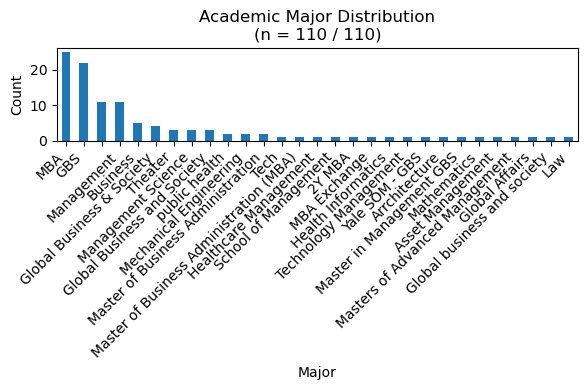


--------------------------------------------------------------------------------
⚧ Gender Distribution
--------------------------------------------------------------------------------


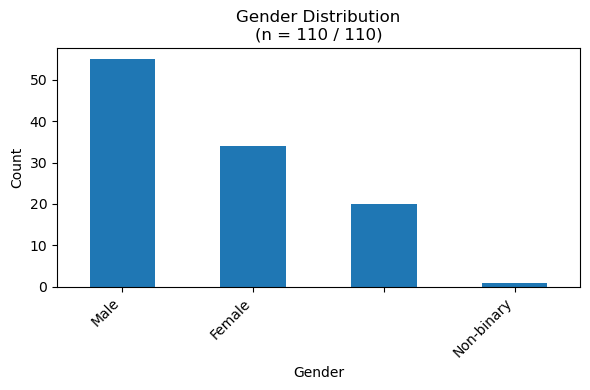


--------------------------------------------------------------------------------
💼 Negotiation Experience Distribution
--------------------------------------------------------------------------------


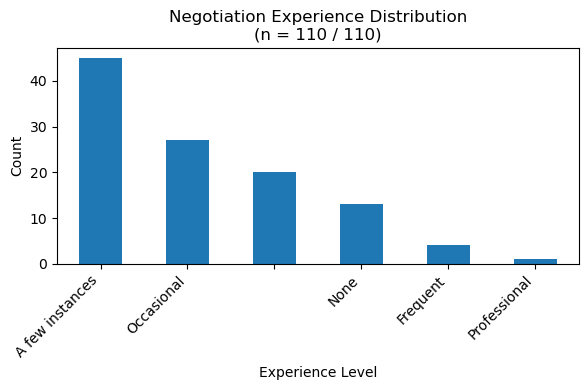


--------------------------------------------------------------------------------
📈 Deal Success Rates by Demographics
--------------------------------------------------------------------------------


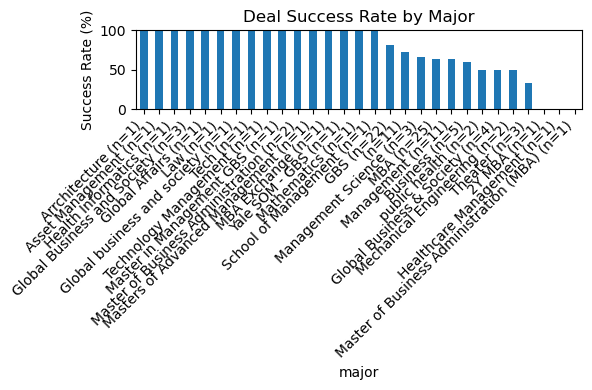

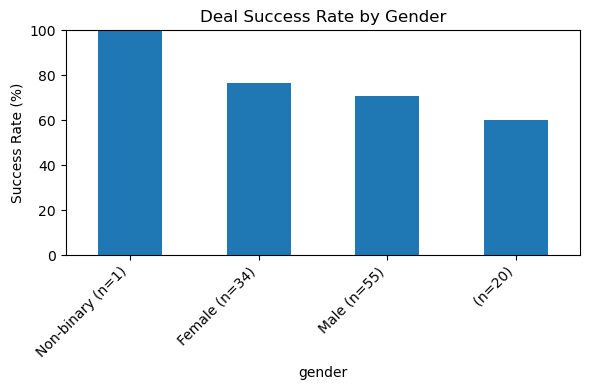

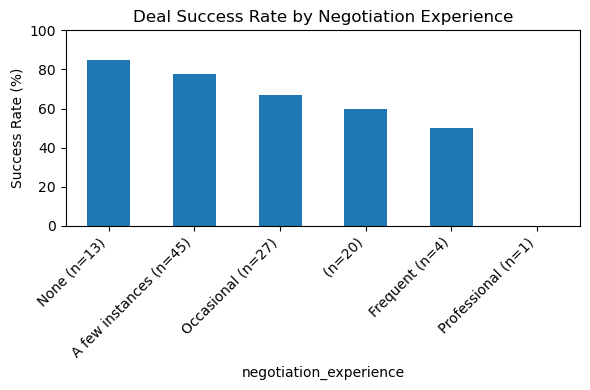

In [15]:
analyze_demographics(df_all)


df_all.dropna(subset = ['final_price'])
df_all = df_all[df_all['status'] == 'completed']
df_all = df_all[df_all['Outcome'].str.contains('Deal')]


                               💰 DEAL PRICE ANALYSIS BY CONFIGURATION                               

Total Successful Deals: 78
Reference points:
  Seller minimum (BATNA): $475,000
  Breakeven price:        $575,000
  Buyer maximum (BATNA):  $675,000



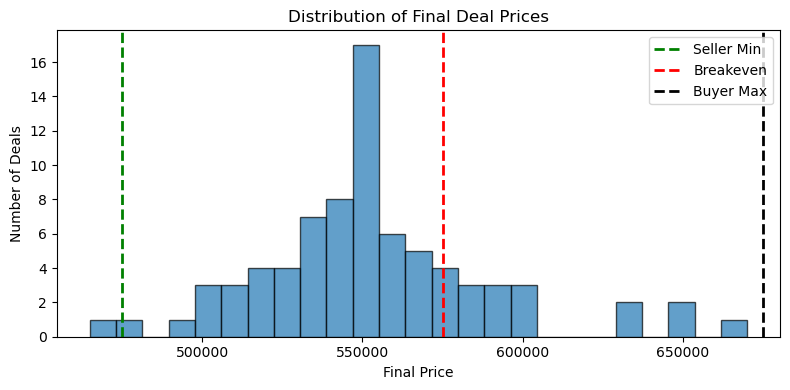

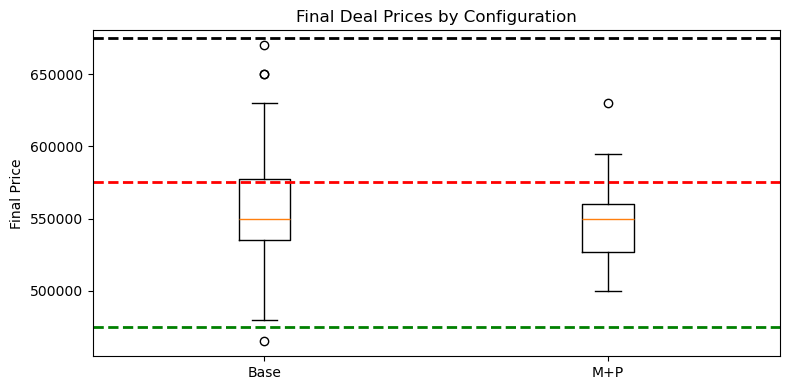

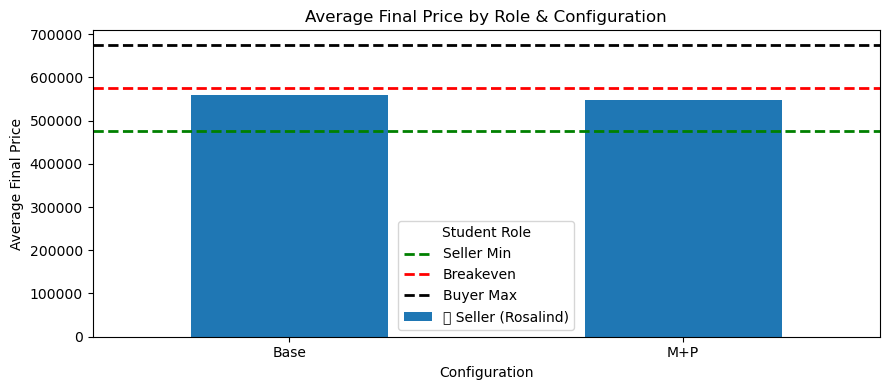

In [16]:
df_deals = get_deals(df_all)
analyze_deal_prices(df_deals)

In [17]:
df_deals

,session_id,student_role,ai_role,ai_model,student_goes_first,use_memory,use_plan,total_rounds,deal_reached,deal_failed,status,created_at,updated_at,major,gender,negotiation_experience,transcript,student_deal_json,ai_deal_json,Config,Duration (min),Outcome,Role,rounds,final_price
0,f81e9731-d2d1-4ff5-b0a8-9cf3c7eabb14,side2,side1,openai/gpt-5,0,0,0,6,True,False,completed,2025-12-10T20:01:46.623542,2025-12-10T20:08:58.218865,MBA,Male,A few instances,"[""Round 1.1 - Fred Starr (Buyer): Rosalind, go...","{""final_price"": 670000}","{""final_price"": 670000}",Base,7.193255,✅ Deal,🏘️ Seller (Rosalind),6,670000.0
1,b37f26ac-3149-4003-950d-b3c9efe5c70a,side2,side1,openai/gpt-5,0,0,0,4,True,False,completed,2025-12-10T19:52:33.419713,2025-12-10T19:59:38.032843,Theater,Female,Occasional,"[""Round 1.1 - Fred Starr (Buyer): Rosalind, go...","{""final_price"": 575000}","{""final_price"": 575000}",Base,7.076886,✅ Deal,🏘️ Seller (Rosalind),4,575000.0
3,1da9f9c4-9450-425b-bc34-d82ef2efaa64,side2,side1,openai/gpt-5,1,1,1,6,True,False,completed,2025-12-10T19:49:47.303769,2025-12-10T20:18:51.619119,GBS,,,"[""Round 1.1 - Rosalind Cain (Seller): Hi Fred!...",None,"{""final_price"": 515000}",M+P,29.071923,✅ Deal,🏘️ Seller (Rosalind),4,515000.0
4,0ad06bea-d0a0-4eed-82be-cd1ea6d5f557,side2,side1,openai/gpt-5,0,0,0,6,True,False,completed,2025-12-10T19:44:35.216180,2025-12-10T19:55:57.919402,MBA,,,"[""Round 1.1 - Fred Starr (Buyer): Rosalind, Fr...","{""final_price"": 465000}","{""final_price"": 465000}",Base,11.378387,✅ Deal,🏘️ Seller (Rosalind),6,465000.0
6,799f52db-616d-4b6b-99fd-488c1c623e31,side2,side1,openai/gpt-5,1,0,0,6,True,False,completed,2025-12-10T19:39:00.537044,2025-12-10T20:05:57.926556,MBA Exchange,,A few instances,"[""Round 1.1 - Rosalind Cain (Seller): Hi! Good...","{""final_price"": 549000}","{""final_price"": 549000}",Base,26.956492,✅ Deal,🏘️ Seller (Rosalind),6,549000.0
7,95e44a5d-6529-49ae-ae99-c146b6cdfc7e,side2,side1,openai/gpt-5,0,0,0,6,True,False,completed,2025-12-10T19:38:10.740468,2025-12-10T19:46:54.169621,MBA,Male,A few instances,"[""Round 1.1 - Fred Starr (Buyer): Rosalind, go...","{""final_price"": 570000}","{""final_price"": 570000}",Base,8.723819,✅ Deal,🏘️ Seller (Rosalind),6,570000.0
8,16eceb2c-fe06-4c6f-8d69-55a8d9624506,side2,side1,openai/gpt-5,1,1,1,6,True,False,completed,2025-12-10T19:37:45.144965,2025-12-10T20:20:18.412894,GBS,Female,A few instances,"[""Round 1.1 - Rosalind Cain (Seller): Hi, can ...","{""final_price"": 585000}","{""final_price"": 585000}",M+P,42.554465,✅ Deal,🏘️ Seller (Rosalind),8,585000.0
10,31db345d-afd0-4714-ac7a-d6681fc76cbe,side2,side1,openai/gpt-5,1,1,1,6,True,False,completed,2025-12-10T19:35:37.852094,2025-12-10T19:58:18.008693,Tech,Male,Occasional,"[""Round 1.1 - Rosalind Cain (Seller): i want t...","{""final_price"": 565000}","{""final_price"": 565000}",M+P,22.669277,✅ Deal,🏘️ Seller (Rosalind),5,565000.0
11,88bdd965-b58a-4bf8-9f8c-877d241e1cb4,side2,side1,openai/gpt-5,0,0,0,6,True,False,completed,2025-12-10T19:35:25.058409,2025-12-10T19:55:52.235733,,,,"[""Round 1.1 - Fred Starr (Buyer): Rosalind, Fr...",None,"{""final_price"": 565000}",Base,20.452955,✅ Deal,🏘️ Seller (Rosalind),5,565000.0
12,50f35769-ef7f-4633-b4ce-69ef5d1ef0b9,side2,side1,openai/gpt-5,0,0,0,6,True,False,completed,2025-12-10T19:35:24.137162,2025-12-10T19:55:38.842334,Business,Male,A few instances,"[""Round 1.1 - Fred Starr (Buyer): Rosalind, Fr...",None,"{""final_price"": 630000}",Base,20.245086,✅ Deal,🏘️ Seller (Rosalind),5,630000.0



                                  📊 COMPREHENSIVE PRICE COMPARISON                                  

Reference points:
  Seller minimum (BATNA): $475,000
  Breakeven price:        $575,000
  Buyer maximum (BATNA):  $675,000



,n_deals,avg_price,median_price,avg_rounds,avg_duration
Config,,,,,
Base,39,559820.5,550000.0,5.7,20.7
M+P,39,547025.6,550000.0,5.7,27.8


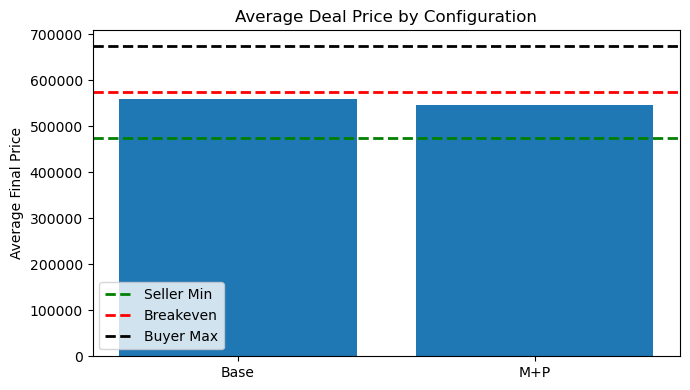

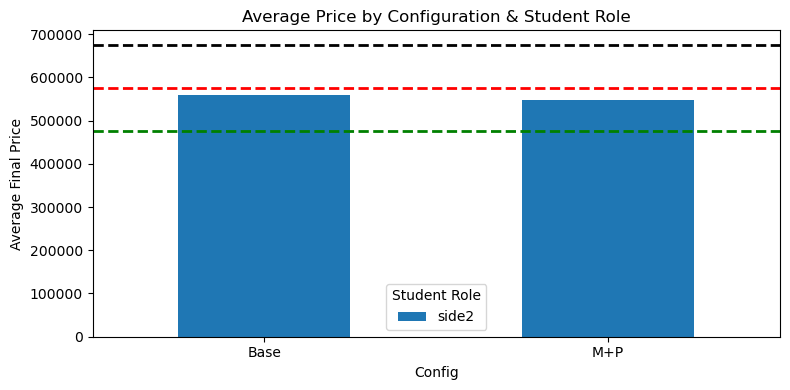

In [18]:
show_price_comparison(df_deals)


                              🚦 WHO GOES FIRST: IMPACT ON FINAL PRICE                               

Reference points:
  Seller minimum (BATNA): $475,000
  Breakeven price:        $575,000
  Buyer maximum (BATNA):  $675,000


--------------------------------------------------------------------------------
📊 Base Configuration
--------------------------------------------------------------------------------


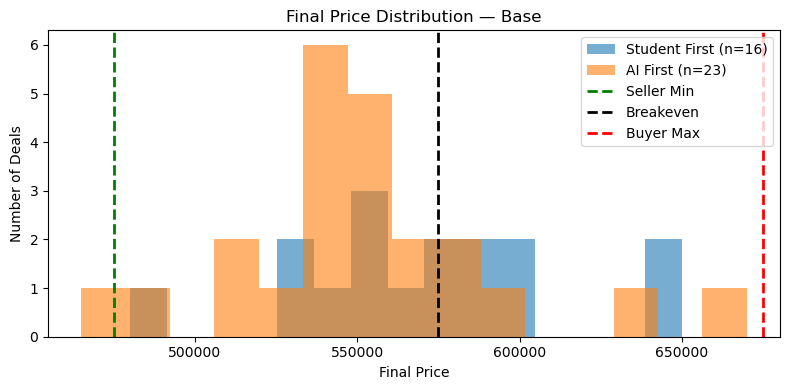

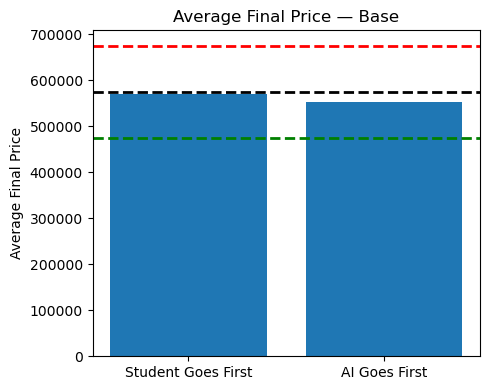

💡 Impact: Student going first leads to HIGHER prices by $19,274 on average.


--------------------------------------------------------------------------------
📊 M+P Configuration
--------------------------------------------------------------------------------


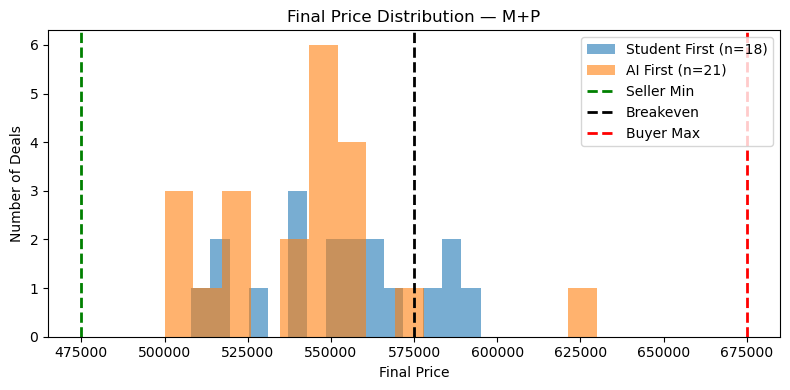

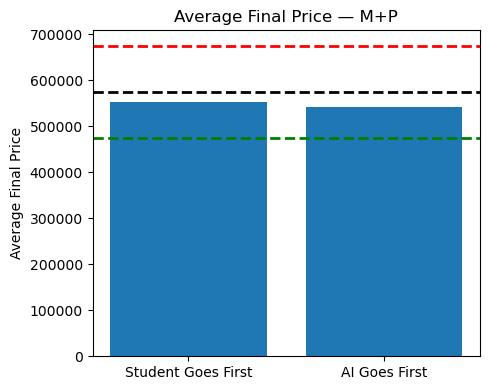

💡 Impact: Student going first leads to HIGHER prices by $9,238 on average.



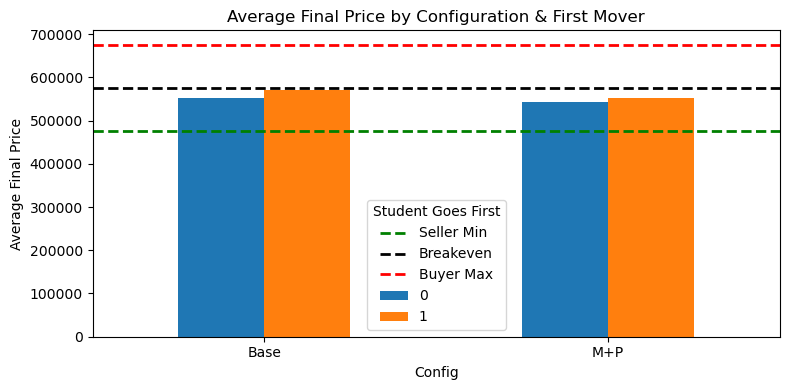

In [19]:
analyze_who_goes_first(df_deals)

In [20]:
# analyze_memory(conn, df_all)

In [21]:
# analyze_plan(conn, df_all)

In [22]:
view_transcript(df_deals)


                                   💬 FULL CONVERSATION TRANSCRIPT                                   

Found 78 successful deals

📋 All Successful Deals - Choose one to view transcript
  0. f81e9731... | 🏘️ Seller (Rosalind) | Base | $670,000 | 6 rounds | 7.2 min | 12-10 20:01
  1. b37f26ac... | 🏘️ Seller (Rosalind) | Base | $575,000 | 4 rounds | 7.1 min | 12-10 19:52
  3. 1da9f9c4... | 🏘️ Seller (Rosalind) | M+P  | $515,000 | 4 rounds | 29.1 min | 12-10 19:49
  4. 0ad06bea... | 🏘️ Seller (Rosalind) | Base | $465,000 | 6 rounds | 11.4 min | 12-10 19:44
  6. 799f52db... | 🏘️ Seller (Rosalind) | Base | $549,000 | 6 rounds | 27.0 min | 12-10 19:39
  7. 95e44a5d... | 🏘️ Seller (Rosalind) | Base | $570,000 | 6 rounds | 8.7 min | 12-10 19:38
  8. 16eceb2c... | 🏘️ Seller (Rosalind) | M+P  | $585,000 | 8 rounds | 42.6 min | 12-10 19:37
 10. 31db345d... | 🏘️ Seller (Rosalind) | M+P  | $565,000 | 5 rounds | 22.7 min | 12-10 19:35
 11. 88bdd965... | 🏘️ Seller (Rosalind) | Base | $565,000 | 5 roun


                                  📊 PERFORMANCE METRICS DASHBOARD                                   

Reference points:
  Seller minimum (BATNA): $475,000
  Breakeven price:        $575,000
  Buyer maximum (BATNA):  $675,000



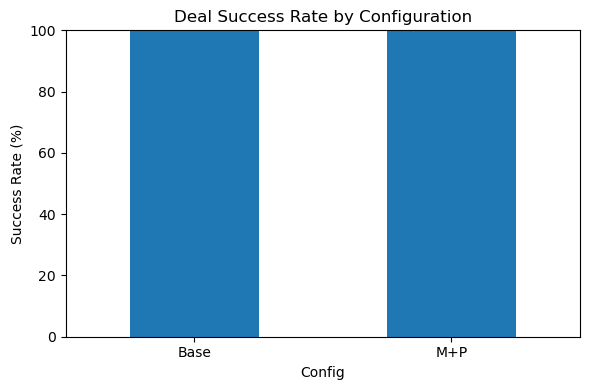

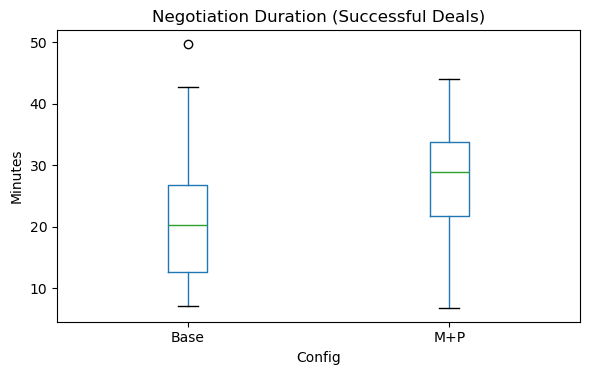

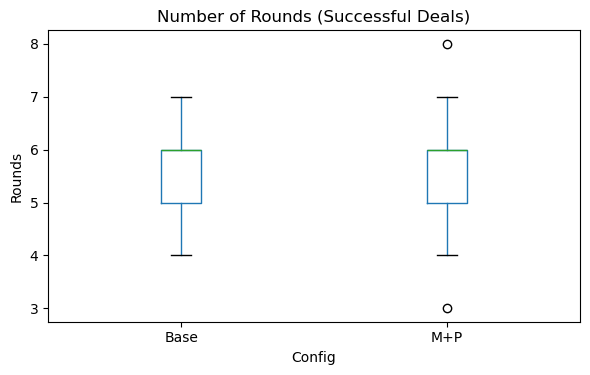

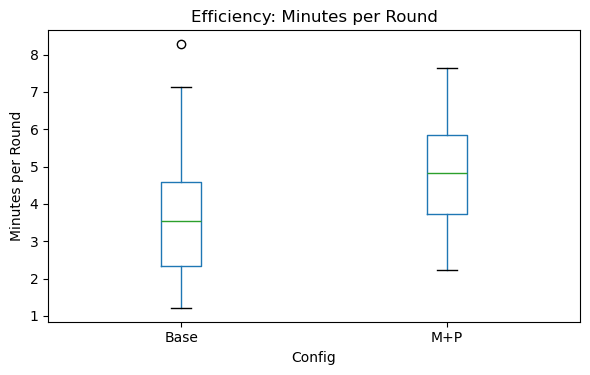

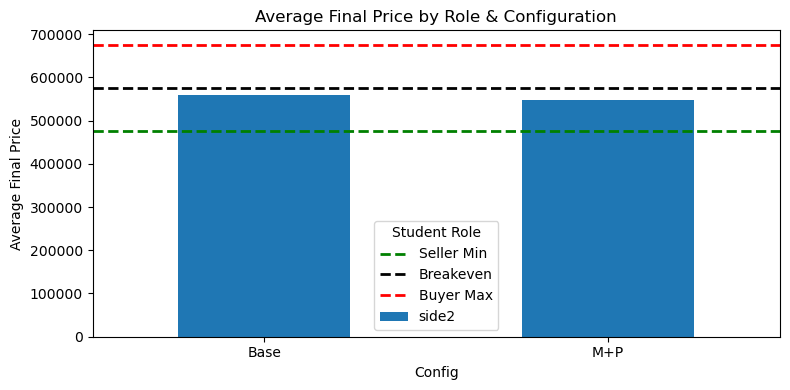

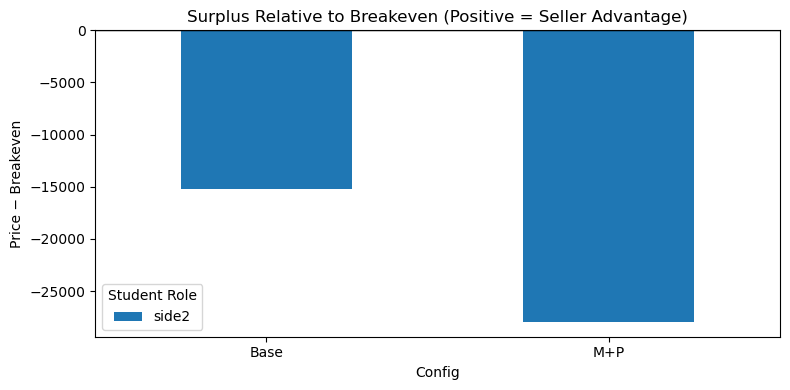

In [23]:
performance_metrics(df_all, df_deals)


                                       📊 TIME WINDOW OVERVIEW                                       



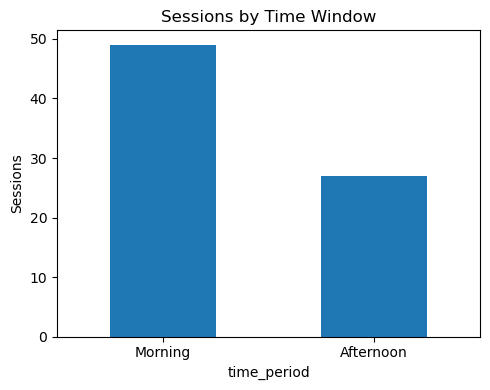

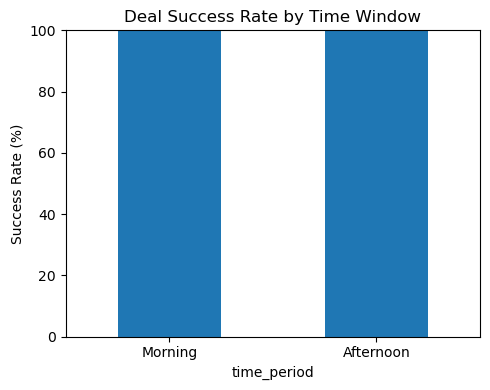


                                        📋 ALL FILTERED DATA                                         



,Session,Period,Role,Config,Outcome,Major,Gender,Exp,Rounds,Final Price,Duration,Created
1,b37f26ac,Afternoon,🏘️ Seller (Rosalind),Base,✅ Deal,Theater,Female,Occasional,4,"$575,000",7.1,12-10 19:52
3,1da9f9c4,Afternoon,🏘️ Seller (Rosalind),M+P,✅ Deal,GBS,,,4,"$515,000",29.1,12-10 19:49
4,0ad06bea,Afternoon,🏘️ Seller (Rosalind),Base,✅ Deal,MBA,,,6,"$465,000",11.4,12-10 19:44
6,799f52db,Afternoon,🏘️ Seller (Rosalind),Base,✅ Deal,MBA Exchange,,A few instances,6,"$549,000",27.0,12-10 19:39
7,95e44a5d,Afternoon,🏘️ Seller (Rosalind),Base,✅ Deal,MBA,Male,A few instances,6,"$570,000",8.7,12-10 19:38
8,16eceb2c,Afternoon,🏘️ Seller (Rosalind),M+P,✅ Deal,GBS,Female,A few instances,8,"$585,000",42.6,12-10 19:37
10,31db345d,Afternoon,🏘️ Seller (Rosalind),M+P,✅ Deal,Tech,Male,Occasional,5,"$565,000",22.7,12-10 19:35
11,88bdd965,Afternoon,🏘️ Seller (Rosalind),Base,✅ Deal,,,,5,"$565,000",20.5,12-10 19:35
12,50f35769,Afternoon,🏘️ Seller (Rosalind),Base,✅ Deal,Business,Male,A few instances,5,"$630,000",20.2,12-10 19:35
13,1c047b8c,Afternoon,🏘️ Seller (Rosalind),M+P,✅ Deal,,,,6,"$550,000",25.3,12-10 19:35



                                  🌅 MORNING SESSION (14:36–15:48)                                   



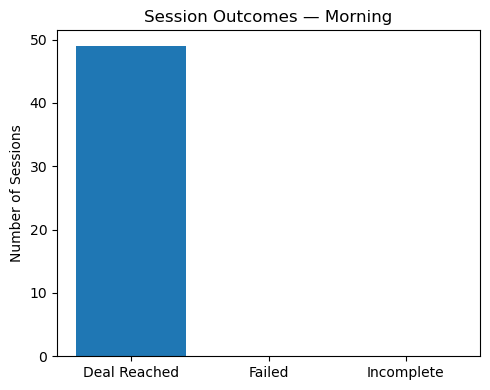

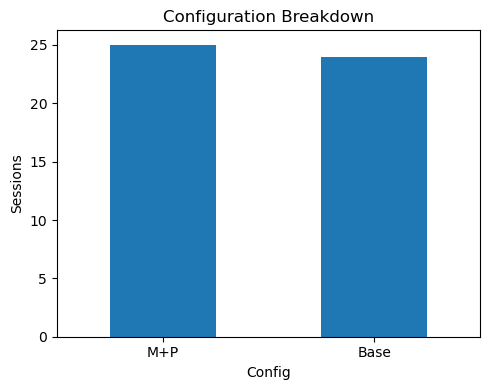

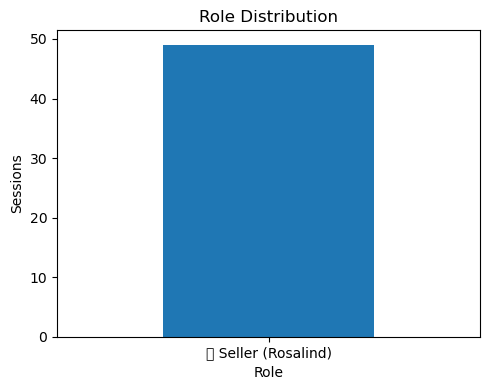

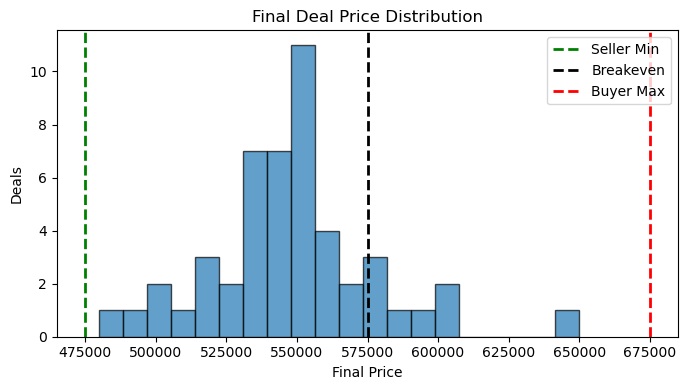

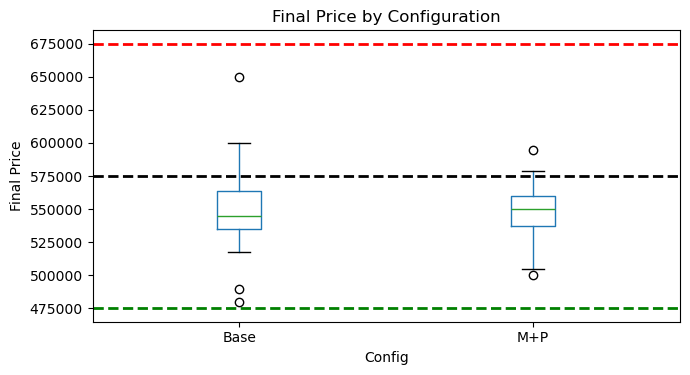

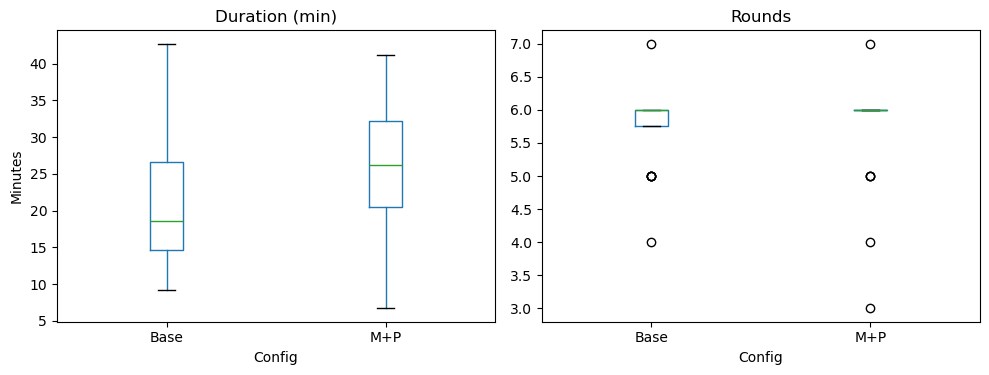


--------------------------------------------------------------------------------
📋 Detailed Session List
--------------------------------------------------------------------------------


,Session,Role,Config,Outcome,Major,Rounds,Price,Duration,Time
46,f8108b66,🏘️ Seller (Rosalind),Base,✅ Deal,Health Informatics,5,"$490,000",16.4,15:37
54,8f327691,🏘️ Seller (Rosalind),Base,✅ Deal,,6,"$545,000",18.6,15:09
56,def6ce77,🏘️ Seller (Rosalind),Base,✅ Deal,public health,6,"$530,000",11.0,15:07
58,ff4187e1,🏘️ Seller (Rosalind),M+P,✅ Deal,GBS,6,"$570,000",20.5,15:00
59,2c58997c,🏘️ Seller (Rosalind),Base,✅ Deal,Global Business & Society,6,"$535,000",9.2,14:59
60,1c64c52d,🏘️ Seller (Rosalind),Base,✅ Deal,Global Business & Society,6,"$600,000",14.9,14:57
62,320f365c,🏘️ Seller (Rosalind),Base,✅ Deal,GBS,6,"$600,000",17.3,14:50
63,583603ec,🏘️ Seller (Rosalind),M+P,✅ Deal,GBS,6,"$537,500",17.6,14:50
65,24a24ce4,🏘️ Seller (Rosalind),M+P,✅ Deal,GBS,4,"$555,000",15.0,14:49
67,da8e805c,🏘️ Seller (Rosalind),M+P,✅ Deal,Management,6,"$540,000",29.4,14:48



                                 🌆 AFTERNOON SESSION (19:21–20:01)                                  



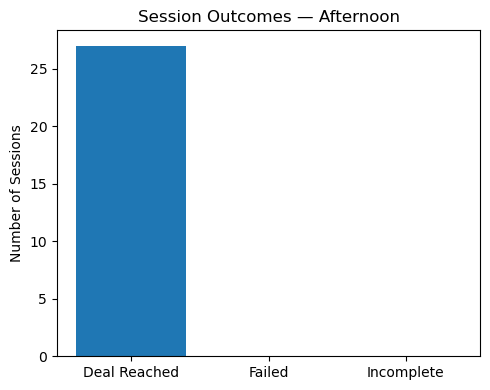

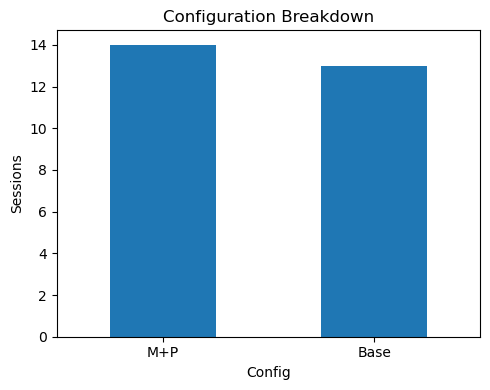

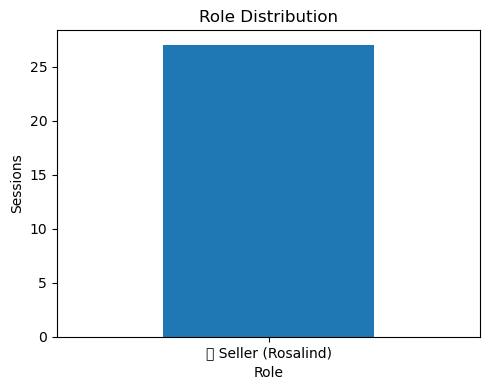

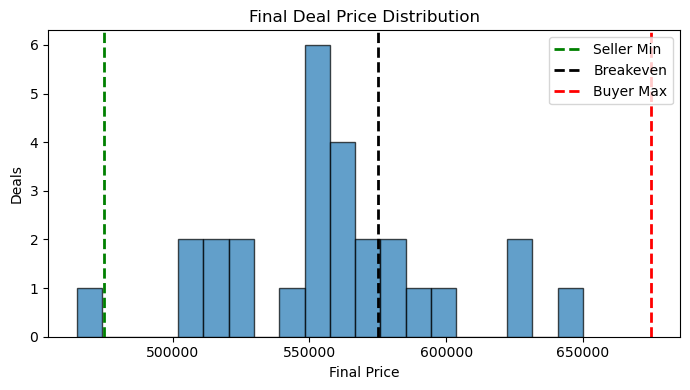

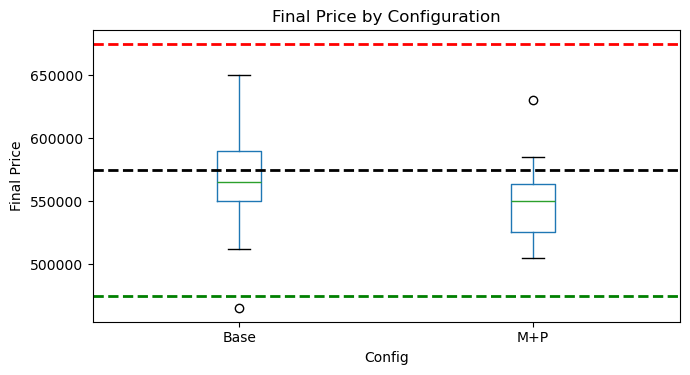

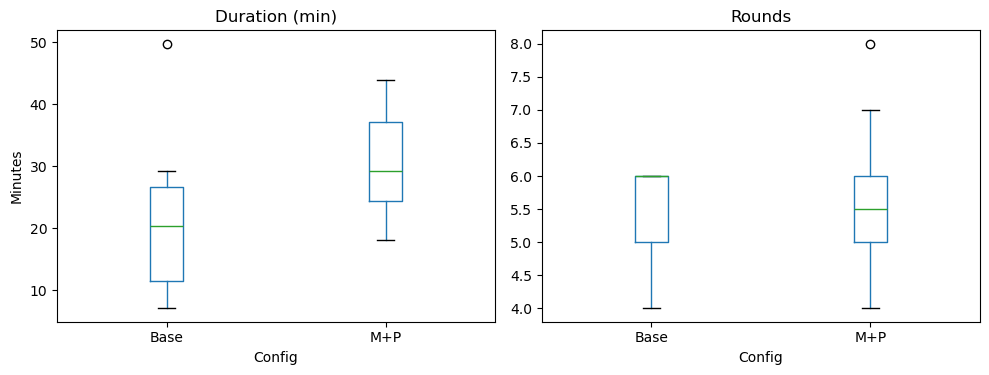


--------------------------------------------------------------------------------
📋 Detailed Session List
--------------------------------------------------------------------------------


,Session,Role,Config,Outcome,Major,Rounds,Price,Duration,Time
1,b37f26ac,🏘️ Seller (Rosalind),Base,✅ Deal,Theater,4,"$575,000",7.1,19:52
3,1da9f9c4,🏘️ Seller (Rosalind),M+P,✅ Deal,GBS,4,"$515,000",29.1,19:49
4,0ad06bea,🏘️ Seller (Rosalind),Base,✅ Deal,MBA,6,"$465,000",11.4,19:44
6,799f52db,🏘️ Seller (Rosalind),Base,✅ Deal,MBA Exchange,6,"$549,000",27.0,19:39
7,95e44a5d,🏘️ Seller (Rosalind),Base,✅ Deal,MBA,6,"$570,000",8.7,19:38
8,16eceb2c,🏘️ Seller (Rosalind),M+P,✅ Deal,GBS,8,"$585,000",42.6,19:37
10,31db345d,🏘️ Seller (Rosalind),M+P,✅ Deal,Tech,5,"$565,000",22.7,19:35
11,88bdd965,🏘️ Seller (Rosalind),Base,✅ Deal,,5,"$565,000",20.5,19:35
12,50f35769,🏘️ Seller (Rosalind),Base,✅ Deal,Business,5,"$630,000",20.2,19:35
13,1c047b8c,🏘️ Seller (Rosalind),M+P,✅ Deal,,6,"$550,000",25.3,19:35


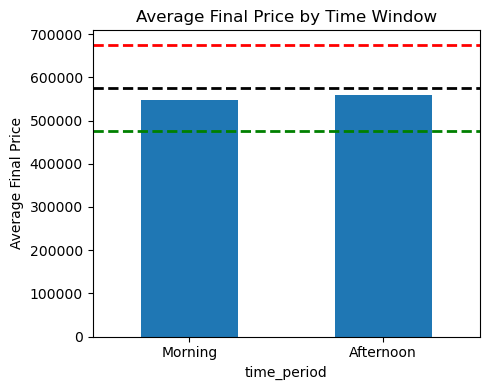

In [24]:
analyze_time_windows(df_all)

In [25]:
# seller_only_analysis(df_all)

In [26]:
conn.close()
print("✅ Database connection closed")

✅ Database connection closed
